# GeoPandas入門（前編）

Pythonで地理空間情報を行う場合、GeoPandasの使い方を覚えておくととても便利です。

例えば、都道府県別の気象データを持っていたとします。そのテーブルデータ(csv)には地理情報と言えば、都道府県の名称くらいしかありません。このような場合、これを日本地図の上に重畳して可視化することはできません。

しかし、このデータに地図上に描画できる情報を与えることさえできれば、好きなデータを地図の上に重ねることができます。このようなことをしたい場合に、GeoPandasの使い方を知っておけば助けになります。

今回は、簡単な例を通じて、GeoPandasの魅力の一端を知ってみましょう。

今回の解析ではGoogle Colaboratoryを利用しています。ローカルでも動作します。

仮にローカルで実行する場合には、いくつかの処理は必要ありませんので都度スキップしてください。

今回利用するデータはこちら

- [平均初婚年齢](https://drive.google.com/file/d/1-AAnnKwZCGlF_V0CiI6XYQ1vm7NjVFO2/view?usp=sharing)
- [日本のシェープファイル](https://drive.google.com/drive/folders/1-D8N-9YYWIyxUeaxyL1Ggq7G_SfrWryR?usp=sharing)

この前編では

- ラスターデータとベクターデータの振り返り
- GeoPandasを利用してベクターデータの読み込みや描画
- csvデータとベクターデータの組み合わせによる解析
- やや高度な描画方法
- 時系列動画（タイムラプス動画）の作成
- Plotlyを用いた可視化例

について紹介します。

## ラスターとベクター

地理空間情報とはいわゆるGISというものです。まずは基礎中の基礎、画像の形式としてラスター、ベクターというものを思い出すに留め、その後、実際にコードを動かしながら地理空間情報に必要な知識である、参照系の概念を説明します（後編にて紹介）。

### ラスターデータ

![image.png](https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/dev-aten/graphics/raster-general/raster_concept.png)

<center>Source: National Ecological Observatory Network (NEON)</center>

ラスターデータとは上のように格子状の中にデータが入ったものです。格子の大きさにより、画像の滑らかさが変わります。格子が細かいラスターデータは、より解像度の高い画像と考えらられ、格子が大きくなれば、荒い画像になります。

この一つ一つの格子をピクセルと呼びます。

ラスターはGeoPandasで扱うより、rasterioなどで扱うことが多いのですが、このピクセル座標を地理座標に置き換え、ピクセル一つ一つをテーブルデータとして扱うことができます。特に初めから地理座標を備えているGeoTIFFデータでは、この変換作業はとても楽です。

![resolution](https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/dev-aten/graphics/raster-general/raster_resolution.png)

<center>Source: National Ecological Observatory Network (NEON) </center>

上の図を見れば明らかです。不鮮明な画像では、ピクセルの形がはっきりとわかりますが、高い解像度のものでは、ピクセルの形は捉えることができません。

ラスターデータは単に写真のようなデータというわけではなく、ピクセルの中に入っている値を用いて発展的な解析を行います。代表的なものとして植生の活性度を示すNDVIやEVIがあります。また地表面温度の推定なども求めることができます（下図参照）。

![SurfaceTemp](https://sorabatake.jp/wp-content/uploads/2018/09/image5-1300x743.png)

ピクセル座標が地理空間情報を含むと、実際に地図上にデータを重ねることができます。

画像自身は自分がどこに当てはまるのかを知っていません。ここに参照となるデータを与えてあげる([georeference](https://www.pasco.co.jp/recommend/word/word089/))と、画像データがどこに位置するべきなのかを判断できます。

### ベクターデータ

続いてベクターです。ベクターはラスターと違い、格子の中にデータを持ちません（ピクセルで構築されていないデータ）。

点のデータ、線のデータ、そしてポリゴンと呼ばれる多角形のデータがこれに当たります。具体的には、市町村区の境界、Google Map上でお気に入りの場所に落としたピンがベクターデータになります。

![vector](https://www.earthdatascience.org/images/earth-analytics/spatial-data/points-lines-polygons-vector-data-types.png)

<center>Source: National Ecological Observatory Network (NEON) </center>

上図を見るとわかるように、ポイントは、一つの座標で構成されています。ラインは少なくとも2点の情報が必要であり、その線は閉じていません。ポリゴンでは、複数の点、線が閉じることが条件となります。もちろん、円もポリゴンです。

ベクターファイルの有名な形式としてはshp(shapefile)があります。GeoJsonも代表的なファイル形式と言えるでしょう。ベクターは数学的に記述されたデータであり、解像度という概念をもっていません。そのため拡大しても縮小しても、変化はありません。

## GeoPandasを触ってみよう

[GeoPandas](https://geopandas.org)とはそもそも何なのか。GeoPandasとはPandasによるテーブルデータの処理と、Shapelyによる幾何学的なデータ処理を併せ持ったものになります。そこにmatplotlibによる描画支援も行われているため、地理空間情報を簡単なテーブルデータで処理できるだけでなく、ちょっとしたコマンドで直接描画まで行えるという優れものです。

![GeoDataFrame](https://geopandas.org/_images/dataframe.svg)

<center>Source: GeoPandas developers.</center>

言葉で説明するよりも、図で見るとわかりやすいです。地理空間情報は様々な形式がありますが、それを上図のようなテーブルにしてしまい、shapelyにより処理される幾何情報はgeometryという列に保存されています。このようなテーブルデータをGeoDataFrameと呼びます。

geomtryでは

- PointsまたはMulti-Points
- LinesまたはMulti-Lines
- PolygonsまたはMulti-Polygons

が基本的なオブジェクトとして扱われます。


ColabでGeoPandas＋αを使う準備をします。下記のセルを実行してください。

GeoPandasには以下の依存関係があります。

- numpy
- pandas
- shapely
- fiona
- pyproj

詳しくは[こちら](https://geopandas.org/getting_started/install.html)のリンク先へ。

In [3]:
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install Folium for Geographic data visualization
# !pip install folium
!pip install plotly-express
!pip install --upgrade plotly
!pip install matplotlib-scalebar
# Use EE in Python
!pip install geemap
!pip install ipygee

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 1s (2,815 kB/s)
Selecting previously unselected

     |████████████████████████████████| 133kB 37.1MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
  Created wheel for ipygee: filename=ipygee-0.0.14-cp37-none-any.whl size=39896 sha256=c9df8627998b334112b13044921f45a33a5eca5fbf94354ad07574d6fa8d13e4
  Stored in directory: /root/.cache/pip/wheels/57/f1/a2/ce9509a072ede592c0c9239ba66a1e9bb8af37bab3ca72fabc
  Created wheel for geetools: filename=geetools-0.6.9-cp37-none-any.whl size=89688 sha256=948044dac4499dd99e4c9743140f7336344b5bd533faf7e8116a132dae6442a3
  Stored in directory: /root/.cache/pip/wheels/d8/28/1d/23473493b5e200165bc4967902c95dea8a8aa1d5384deb2759
Successfully built ipygee geetools


In [ ]:
# Colab使用時
import os
os.kill(os.getpid(), 9)

In [1]:
# Colab使用時

# Driveのマウント
# Filesからもワンクリックでマウント可能です
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ライブラリのインポートを行います。全てがインストールされていれば、エラーなく実行できます。

In [2]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium
import plotly_express as px
from datetime import datetime
import geemap
from ipygee import*

ModuleNotFoundError: ignored

データを使って実際に解析をしてみましょう。

今回は、初婚の平均年齢を可視化してみましょう（どうして結婚の年齢を可視化するのに深い意図はございません）。

### 初婚年齢データの読み込み

In [ ]:
marriageDf = pd.read_csv('/content/drive/MyDrive/Sorabatake/marriage.csv')

データの中身を確認します。

In [ ]:
marriageDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cat01_code        680 non-null    int64  
 1   年齢(5歳階級)          680 non-null    object 
 2   cat02_code        680 non-null    int64  
 3   世帯の主な仕事           680 non-null    object 
 4   cat03_code        680 non-null    int64  
 5   総数・再掲             680 non-null    object 
 6   cat04_code        680 non-null    int64  
 7   夫・妻               680 non-null    object 
 8   area_code         680 non-null    int64  
 9   都道府県（特別区−指定都市再掲）  680 non-null    object 
 10  time_code         680 non-null    int64  
 11  時間軸(年次)           680 non-null    object 
 12  unit              680 non-null    object 
 13  value             680 non-null    float64
dtypes: float64(1), int64(6), object(7)
memory usage: 74.5+ KB


こちらは[e-stat](https://www.e-stat.go.jp/dbview?sid=0003413966)からダウロードしたものとなります。ダウンロード前にレイアウトをいじってからダウンロードしてありますが、それ以外には特に加工はしていません。

ここでは、簡単なデータクリーニングも含めて進めていきましょう。

In [ ]:
marriageDf.head()

,cat01_code,年齢(5歳階級),cat02_code,世帯の主な仕事,cat03_code,総数・再掲,cat04_code,夫・妻,area_code,都道府県（特別区−指定都市再掲）,time_code,時間軸(年次),unit,value
0,80,平均初婚年齢,100,総数,100,総数,100,夫,1000,北海道,2019000000,2019年,歳,30.8
1,80,平均初婚年齢,100,総数,100,総数,100,夫,1000,北海道,2018000000,2018年,歳,30.8
2,80,平均初婚年齢,100,総数,100,総数,100,夫,1000,北海道,2017000000,2017年,歳,30.8
3,80,平均初婚年齢,100,総数,100,総数,100,夫,1000,北海道,2016000000,2016年,歳,30.8
4,80,平均初婚年齢,100,総数,100,総数,100,夫,1000,北海道,2015000000,2015年,歳,30.7


In [ ]:
marriageDf.describe(include='all')

,cat01_code,年齢(5歳階級),cat02_code,世帯の主な仕事,cat03_code,総数・再掲,cat04_code,夫・妻,area_code,都道府県（特別区−指定都市再掲）,time_code,時間軸(年次),unit,value
count,680.0,680,680.0,680,680.0,680,680.000000,680,680.000000,680,6.800000e+02,680,680,680.000000
unique,NaN,1,NaN,1,NaN,1,NaN,2,NaN,68,NaN,5,1,NaN
top,NaN,平均初婚年齢,NaN,総数,NaN,総数,NaN,妻,NaN,静岡市,NaN,2016年,歳,NaN
freq,NaN,680,NaN,680,NaN,680,NaN,340,NaN,10,NaN,136,680,NaN
mean,80.0,NaN,100.0,NaN,100.0,NaN,105.000000,NaN,23430.588235,NaN,2.017000e+09,NaN,NaN,30.130441
std,0.0,NaN,0.0,NaN,0.0,NaN,5.003681,NaN,12992.852446,NaN,1.415255e+06,NaN,NaN,0.944747
min,80.0,NaN,100.0,NaN,100.0,NaN,100.000000,NaN,1000.000000,NaN,2.015000e+09,NaN,NaN,28.500000
25%,80.0,NaN,100.0,NaN,100.0,NaN,100.000000,NaN,13075.000000,NaN,2.016000e+09,NaN,NaN,29.200000
50%,80.0,NaN,100.0,NaN,100.0,NaN,105.000000,NaN,23050.000000,NaN,2.017000e+09,NaN,NaN,30.200000
75%,80.0,NaN,100.0,NaN,100.0,NaN,110.000000,NaN,34025.000000,NaN,2.018000e+09,NaN,NaN,30.900000


列名を変更します。

In [ ]:
marriageDf = marriageDf.loc[:,['夫・妻','都道府県（特別区−指定都市再掲）','時間軸(年次)','value']].\
rename(columns={'夫・妻':'sex','都道府県（特別区−指定都市再掲）':'prefecture','時間軸(年次)':'year','value':'avgAge'}).copy()

続いて、値も編集します。

具体的には、

- 夫はmale、妻はfemale
- xxxx年から年を削除
- 都道府県レベルのみ抽出

します。

In [ ]:
marriageDf.sex = marriageDf.sex.replace('夫','male',regex=False).replace('妻','female',regex=False)
marriageDf.year = marriageDf.year.replace('年$','',regex=True)
# marriageDf.year = pd.to_datetime(marriageDf.year, format = '%Y').dt.to_period('y')
marriageDf.year = marriageDf.year.astype('int64')

In [ ]:
includeStr = ['県$','道$','都$','府$']
marriageDf = marriageDf.loc[marriageDf.prefecture.str.contains('|'.join(includeStr)),:].reset_index(drop=True)

In [ ]:
marriageDf.describe(include='all') # describe all variables

,sex,prefecture,year,avgAge
count,470,470,470.00000,470.000000
unique,2,47,NaN,NaN
top,male,山形県,NaN,NaN
freq,235,10,NaN,NaN
mean,NaN,NaN,2017.00000,29.986809
std,NaN,NaN,1.41572,0.911568
min,NaN,NaN,2015.00000,28.500000
25%,NaN,NaN,2016.00000,29.100000
50%,NaN,NaN,2017.00000,30.100000
75%,NaN,NaN,2018.00000,30.800000


初婚年齢が最も低い値を探してみましょう。

In [ ]:
marriageDf.loc[marriageDf.avgAge == marriageDf.avgAge.min(),:]

,sex,prefecture,year,avgAge
437,female,佐賀県,2017,28.5


初婚年齢が最も高い値を探してみましょう。



In [ ]:
marriageDf.loc[marriageDf.avgAge == marriageDf.avgAge.max(),:]

,sex,prefecture,year,avgAge
64,male,東京都,2015,32.5


都道府県レベルで見ると、佐賀県が最も早く、東京都が最も遅く結婚していることがわかります。



### ベクターファイルの読み込み

[GADM](https://gadm.org/download_country_v3.html)からファイルをダウンロードします。

シェープファイルをダウンロードし、解凍すると以下のファイルが含まれています。

- .cpg
- .dbf
- .prj
- .shp
- .shx

です。geopandasではシェープファイルを読み込む際に、.shpしか指定しません。しかし、GeoPandasでデータを読み込むためには、.shp、.dbf、そして.shxは同じフォルダに存在している必要があります。仮にこれらのファイルが欠けてしまっている場合、pythonはエラーを返します。解凍したファイルからshpだけを残して他のファイルを削除しないようにしましょう。



In [ ]:
jpnShp = gpd.read_file('/content/drive/MyDrive/Sorabatake/japanSHP/gadm36_JPN_1.shp')

In [ ]:
jpnShp.head()

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,JPN,Japan,JPN.1_1,Aichi,Aiti,愛知県,Ken,Prefecture,None,JP.AI,"MULTIPOLYGON (((137.00780 34.65997, 137.00803 ..."
1,JPN,Japan,JPN.2_1,Akita,None,秋田県,Ken,Prefecture,None,JP.AK,"MULTIPOLYGON (((139.55725 39.20330, 139.55765 ..."
2,JPN,Japan,JPN.3_1,Aomori,None,青森県,Ken,Prefecture,None,JP.AO,"MULTIPOLYGON (((140.33719 41.04913, 140.33714 ..."
3,JPN,Japan,JPN.4_1,Chiba,Tiba|Tsiba,千葉県,Ken,Prefecture,None,JP.CH,"MULTIPOLYGON (((139.82487 34.98967, 139.82434 ..."
4,JPN,Japan,JPN.5_1,Ehime,None,愛媛県,Ken,Prefecture,None,JP.EH,"MULTIPOLYGON (((132.55859 32.91224, 132.55904 ..."


今回は行政レベル１を利用しているため、都道府県レベルでのデータを利用することができます。

データフレーム内でgeometryの列が地図上に対象を描画するために必要な情報になります。

geopandasではフィルタリングもお手の物です。Pandasに慣れている場合には、問題なくデータのクリーニングが行えます。データの操作を行う前に、簡単な可視化を行ってみましょう。

下のコマンドは3行になっていますが、`GeoDataFrame.plot()`で描画することが可能です。

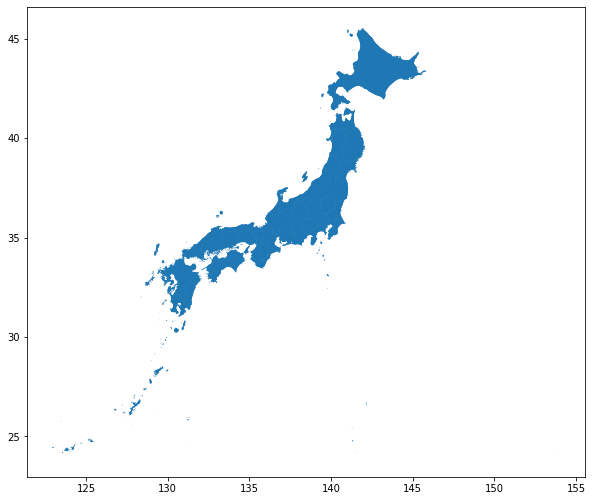

In [ ]:
ax = jpnShp.plot(figsize=(10, 10))
jpnShp.plot(ax=ax)
plt.show();

今回は都道府県レベルのデータを利用していますので、境界も描画します。

併せて、名前も重畳します。

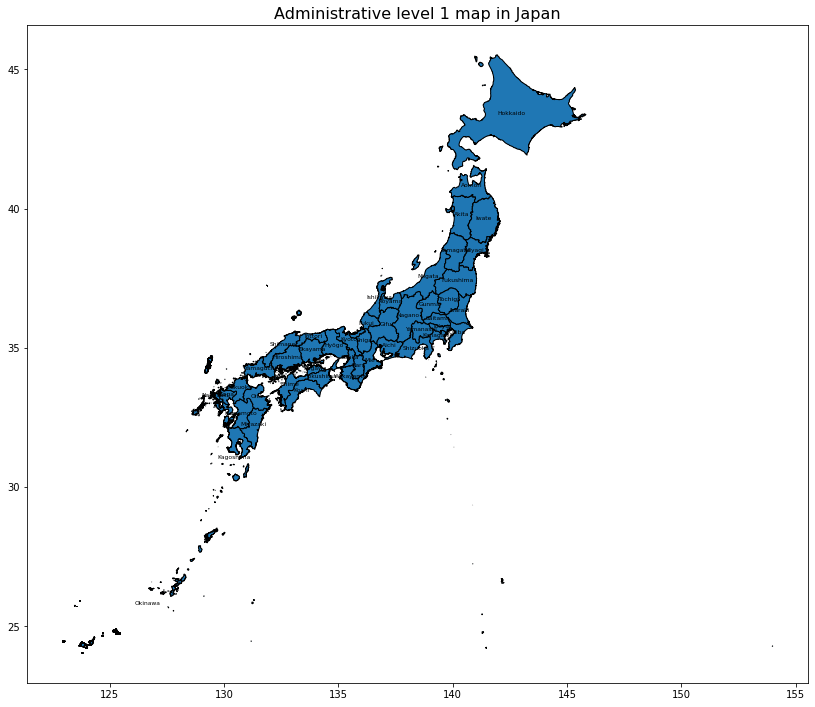

In [ ]:
# 日本のシェープデータを可視化する
ax = jpnShp.plot(figsize=(14, 14))
jpnShp.apply(lambda x: ax.annotate(s=x.NAME_1, xy=x.geometry.centroid.coords[0], ha='center', color = 'black', size = 6),axis=1)
jpnShp.plot(ax = ax, edgecolors='black')
plt.title('Administrative level 1 map in Japan', fontsize=16)
plt.show();

GeoDataFramedではShapelyとmatplotlibにより、簡単にベクターデータを可視化することができます。それでは、この図と先ほど取得したe-statのデータを結合し、さらに描画を行います。

### shpとcsvの結合

シェープファイルのようなデータは、地図上にデータを投影するために必要なデータを既に持っています。単なるテーブルデータは、このようなデータを持っていません。しかし、今回のシェープファイルは都道府県の形を描画する以上のデータを含んでいません。

例えば、果物の都道府県別収穫量のデーブルデータを持っているとして、一方でこのデータには地図上にデータを描くための情報は含まれていません。このような場合に上で示したシェープファイルを利用すれば、果物の収穫量を持った都道府県のデータ(GeoDataFrame）が作成できます。

今回は、平均初婚年齢ですが、やることは同じです。早速試してみましょう。

In [ ]:
# 不必要な列の削除
japan = jpnShp.loc[:,['NAME_1','NL_NAME_1','geometry']].copy()

In [ ]:
combDf = japan.merge(marriageDf,left_on='NL_NAME_1',right_on='prefecture',how='left') # データの結合
combDf.head() # check

,NAME_1,NL_NAME_1,geometry,sex,prefecture,year,avgAge
0,Aichi,愛知県,"MULTIPOLYGON (((137.00780 34.65997, 137.00803 ...",male,愛知県,2019,31.0
1,Aichi,愛知県,"MULTIPOLYGON (((137.00780 34.65997, 137.00803 ...",male,愛知県,2018,30.9
2,Aichi,愛知県,"MULTIPOLYGON (((137.00780 34.65997, 137.00803 ...",male,愛知県,2017,30.9
3,Aichi,愛知県,"MULTIPOLYGON (((137.00780 34.65997, 137.00803 ...",male,愛知県,2016,30.9
4,Aichi,愛知県,"MULTIPOLYGON (((137.00780 34.65997, 137.00803 ...",male,愛知県,2015,30.9


再度、描画を行います。今度は、2019年の平均初婚年齢を日本地図に重畳します。

In [ ]:
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable

縮尺や方位を入れないとGIS屋さんに怒られるので、入れ忘れないようにしましょう。

Pythonで縮尺を入れるためには、[ScaleBar](https://pypi.org/project/matplotlib-scalebar/0.4.1/)を利用するのが良いです（Cartopyを使えばもっと正確です）。個人的にはPythonでの縮尺追加は面倒です。もっとシンプルに論文で使える、プレゼンで使える[地理空間情報の可視化](https://paleolimbot.github.io/ggspatial/articles/ggspatial.html)であればRの方が得意かと思います。

`ScaleBar`では1ピクセルあたりの長さと、その単にを指定する必要があります。今回は50とkmを指定していますので、1ピクセルあたり50kmという計算になります。また長さは、 1, 2, 5, 10, 15, 20, 25, 50, 75, 100, 125, 150, 200, 500 or 750のみしか扱えませんので、縮尺と実際の長さにはややずれが生じることが考えられます。細かい精度まで気にしなければならない場合には、自分で緯度経度を基にして距離を算出して縮尺を作るのが良いと思います。

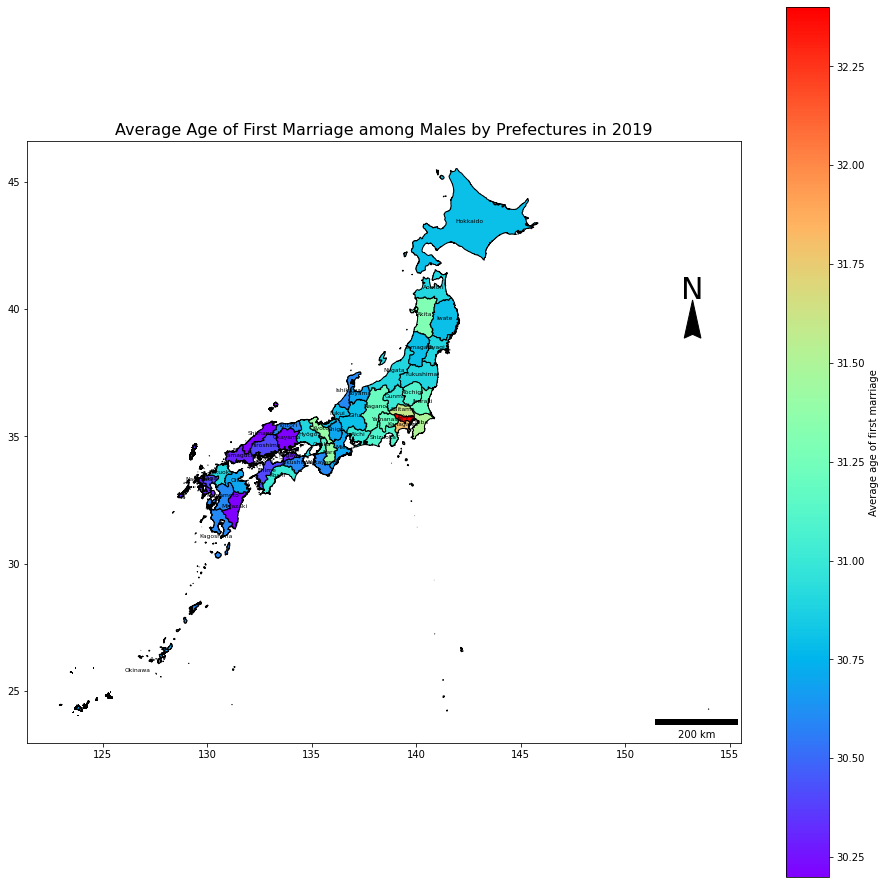

In [ ]:
# 男性
# 方位の作成についての参考記事：
## https://mohammadimranhasan.com/geospatial-data-mapping-with-python/
combDf2019M = combDf.loc[(combDf.year == 2019)&(combDf.sex == 'male'),:].reset_index(drop=True).copy()
ax = combDf2019M.plot(figsize=(16, 16))
scalebar = ScaleBar(50, location='lower right',units='km')
ax.add_artist(scalebar) # 200km
ax.text(x=153.215-0.55, y=40.4, s='N', fontsize=30) # North Arrow
ax.arrow(153.215, 39.36, 0, 1, length_includes_head=True,
          head_width=0.8, head_length=1.5, overhang=.1, facecolor='k') # North Arrow
combDf2019M.apply(lambda x: ax.annotate(s=x.NAME_1, xy=x.geometry.centroid.coords[0], ha='center', color = 'black', size = 6),axis=1)
combDf2019M.plot(column='avgAge', cmap = 'rainbow', edgecolors='black', ax = ax, legend=True,legend_kwds={'label': "Average age of first marriage",'orientation': "vertical"})
plt.title('Average Age of First Marriage among Males by Prefectures in 2019', fontsize=16)
plt.show();

図を見ると、東京が平均初婚年齢が高いことが分かります。その一方で西日本側、特に中国・四国・九州地方では平均初婚年齢がやや若いのがわかるかと思います。

このように、単に値としてみるより、地図で可視化するというのは、非常にわかりやすく、大まかな地理的な変異を捉えることに役立ちます。

加えて女性も見てみましょう。

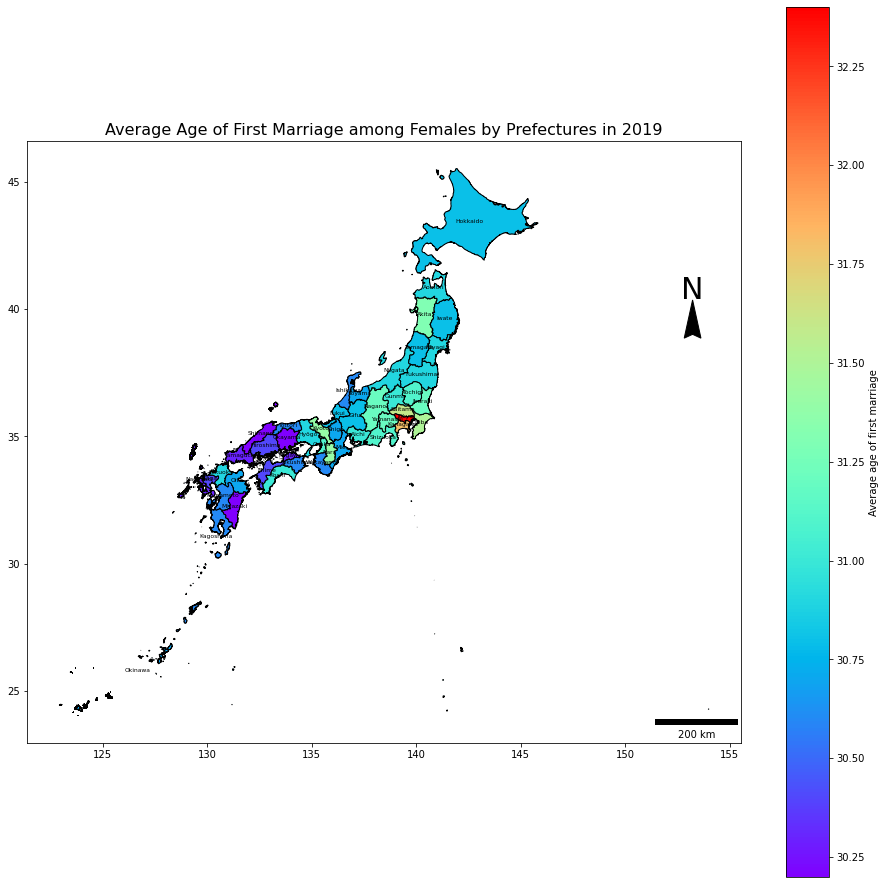

In [ ]:
# 女性
combDf2019F = combDf.loc[(combDf.year == 2019)&(combDf.sex == 'female'),:].reset_index(drop=True).copy()
ax = combDf2019F.plot(figsize=(16, 16))
scalebar = ScaleBar(50, location='lower right',units='km')
ax.add_artist(scalebar) # 200km
ax.text(x=153.215-0.55, y=40.4, s='N', fontsize=30) # North Arrow
ax.arrow(153.215, 39.36, 0, 1, length_includes_head=True,
          head_width=0.8, head_length=1.5, overhang=.1, facecolor='k') # North Arrow
combDf2019F.apply(lambda x: ax.annotate(s=x.NAME_1, xy=x.geometry.centroid.coords[0], ha='center', color = 'black', size = 6),axis=1)
combDf2019M.plot(column='avgAge', cmap = 'rainbow', edgecolors='black', ax = ax, legend=True,legend_kwds={'label': "Average age of first marriage",'orientation': "vertical"})
plt.title('Average Age of First Marriage among Females by Prefectures in 2019', fontsize=16)
plt.show();

女性も傾向は同じですね！

これらの図が[コロプレスマップ](https://note.com/kinari_iro/n/na646fa70f538)と呼ばれるものです。

5年分をまとめて描画します。このようにすることで時間ごとの変化が分かりやすくなります。

In [ ]:
combDf2018M = combDf.loc[(combDf.year == 2018)&(combDf.sex == 'male'),:].reset_index(drop=True).copy()
combDf2017M = combDf.loc[(combDf.year == 2017)&(combDf.sex == 'male'),:].reset_index(drop=True).copy()
combDf2016M = combDf.loc[(combDf.year == 2016)&(combDf.sex == 'male'),:].reset_index(drop=True).copy()
combDf2015M = combDf.loc[(combDf.year == 2015)&(combDf.sex == 'male'),:].reset_index(drop=True).copy()

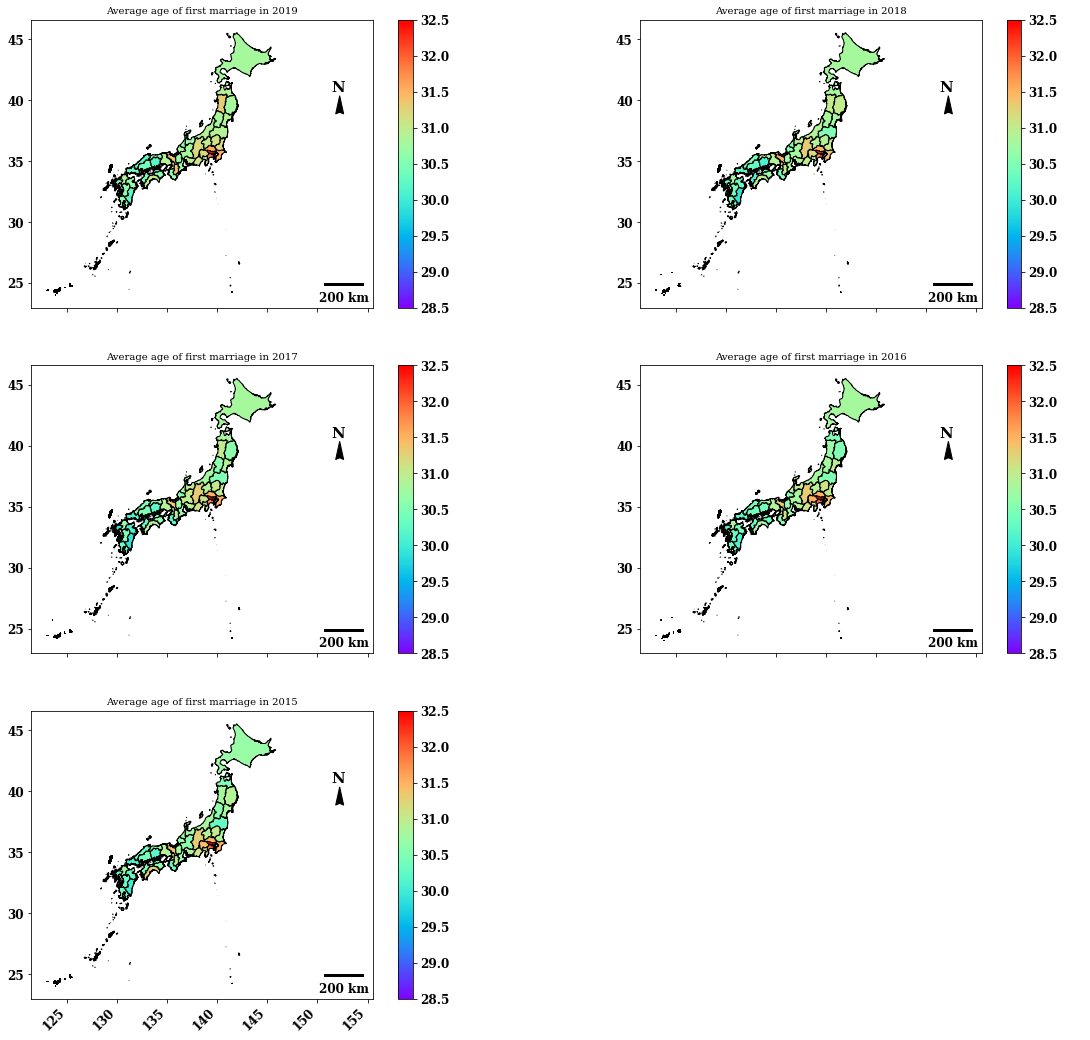

In [ ]:
with plt.rc_context(rc={'font.family': 'serif', 'font.weight': 'bold', 'font.size': 12}):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize = (20,20))
    fig.autofmt_xdate(rotation = 45)
    # 2019
    scalebar = ScaleBar(50, location='lower right',units='km')
    combDf2019M.plot(column='avgAge', cmap = 'rainbow', edgecolors='black', ax = ax1, legend=True,vmin=28.5, vmax=32.5)
    ax1.set_title('Average age of first marriage in 2019', fontsize=10)
    ax1.text(x=152.215-0.85, y=40.7, s='N', fontsize=15) # North Arrow
    ax1.arrow(152.215, 39.36, 0, 1, length_includes_head=True, head_width=0.8, head_length=1.5, overhang=.1, facecolor='k') # North Arrow
    ax1.add_artist(scalebar)
    # 2018
    scalebar = ScaleBar(50, location='lower right',units='km')
    combDf2018M.plot(column='avgAge', cmap = 'rainbow', edgecolors='black', ax = ax2, legend=True,vmin=28.5, vmax=32.5)
    ax2.set_title('Average age of first marriage in 2018', fontsize=10)
    ax2.text(x=152.215-0.85, y=40.7, s='N', fontsize=15) # North Arrow
    ax2.arrow(152.215, 39.36, 0, 1, length_includes_head=True, head_width=0.8, head_length=1.5, overhang=.1, facecolor='k') # North Arrow
    ax2.add_artist(scalebar)
    # 2017
    scalebar = ScaleBar(50, location='lower right',units='km')
    combDf2017M.plot(column='avgAge', cmap = 'rainbow', edgecolors='black', ax = ax3, legend=True, vmin=28.5, vmax=32.5)
    ax3.set_title('Average age of first marriage in 2017', fontsize=10)
    ax3.text(x=152.215-0.85, y=40.7, s='N', fontsize=15) # North Arrow
    ax3.arrow(152.215, 39.36, 0, 1, length_includes_head=True, head_width=0.8, head_length=1.5, overhang=.1, facecolor='k') # North Arrow
    ax3.add_artist(scalebar)
    # 2016
    scalebar = ScaleBar(50, location='lower right',units='km')
    combDf2016M.plot(column='avgAge', cmap = 'rainbow', edgecolors='black', ax = ax4, legend=True, vmin=28.5, vmax=32.5)
    ax4.set_title('Average age of first marriage in 2016', fontsize=10)
    ax4.text(x=152.215-0.85, y=40.7, s='N', fontsize=15) # North Arrow
    ax4.arrow(152.215, 39.36, 0, 1, length_includes_head=True, head_width=0.8, head_length=1.5, overhang=.1, facecolor='k') # North Arrow
    ax4.add_artist(scalebar)
    # 2015
    scalebar = ScaleBar(50, location='lower right',units='km')
    combDf2015M.plot(column='avgAge', cmap = 'rainbow', edgecolors='black', ax = ax5, legend=True, vmin=28.5, vmax=32.5)
    ax5.set_title('Average age of first marriage in 2015', fontsize=10)
    ax5.text(x=152.215-0.85, y=40.7, s='N', fontsize=15) # North Arrow
    ax5.arrow(152.215, 39.36, 0, 1, length_includes_head=True, head_width=0.8, head_length=1.5, overhang=.1, facecolor='k') # North Arrow
    ax5.add_artist(scalebar)
    # Blank
    ax6.axis('off')
    # plt.tight_layout(pad=4)
    plt.show();

2015〜2019の5年間で、傾向に大きな変化がないことがわかります。

続けて、時系列動画（タイムラプス動画）を作成しましょう。地図の可視化では動画を見せる方が理解が早かったりします。今回は五年間のデータですが、これが30年間のような長いスケールになると、時間変化していく様子は動画の方が理解しやすくなります。

動画作成手順としては、png画像を作成し、`ffmpeg`を利用します。

In [ ]:
maleDf = combDf.loc[combDf.sex == 'male',:] # Extract males' values
dateMin = maleDf['year'].min()
n_years = maleDf['year'].nunique()

In [ ]:
# 画像とアニメーションの参考記事
## https://qiita.com/croquette0212/items/8ff251d5da77e803c253
## https://medium.com/tech-carnot/time-lapse-choropleth-map-visualization-using-geopandas-8adb77a7d14
for i in range(0,n_years):
    nyear = dateMin + i
    #Get cumulative df till that date
    dfYear = maleDf.loc[maleDf['year'] == nyear,:]

    fig, ax = plt.subplots(1, figsize=(10,8))
    dfYear.plot(column='avgAge',
                cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
    # remove the axis
    ax.axis('off')
    # add a title
    ax.set_title('Average Age of First Marriage among Males', 
                 fontdict={'fontsize': '25', 'fontweight' : '3'})
    
    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='rainbow', 
            norm=plt.Normalize(vmin=dfYear['avgAge'].min(), vmax=dfYear['avgAge'].max()))
    # add the colorbar to the figure
    cbar = fig.colorbar(sm)
    fontsize = 20
    
    # Positions for the date
    date_x = 140
    date_y = 30
    syear = str(nyear)
    ax.text(date_x, date_y, 
            f"{syear}", 
            color='black',
            fontsize=fontsize)
    fig.savefig(f"/content/drive/MyDrive/Sorabatake/videoff/frame_{i:03d}.png", 
                dpi=100, bbox_inches='tight')
    plt.close()

画像の準備ができました。上の保存フォルダについては、ご自身の好きなフォルダで問題ありません。

この画像を用いて、`ffmpeg`で動画の作成を開始します。今回はターミナルのコマンドを持ちますので、!を先頭につけたコマンドを追加しています。

In [ ]:
imgDir = '/content/drive/MyDrive/Sorabatake/videoff' # 動画の保存場所

if not os.path.exists(imgDir):
  os.makedirs(imgDir) # フォルダ作成

# 同じ動画名にならないように注意
!ffmpeg -framerate 1 -i "$imgDir/frame_%03d.png" -c:v h264 -r 30 "$imgDir/avgAgevideo.mp4"

作成した動画はvlcなどの動画ソフトで閲覧が可能です。

### Plotlyを使う

描画として、さらにPlotlyを利用してみましょう。こちらでは動的な可視化が行えるようになります。

In [ ]:
fig = px.choropleth(combDf,                            # データフレーム
                     locations="NAME_1",           # 場所の名称を取得
                     color="avgAge",                     # 色付けするデータ指定
                     hover_name="NAME_1",              # マウスホバーで表示するデータ
                     animation_frame="year",        # 時間データ指定
                     projection="natural earth",        # 投影する面指定
                     color_continuous_scale = 'Peach',  # 色指定
                     range_color=[28,33]            # 色付けするデータの範囲を指定
                     )        
fig.update_geos(
    center=dict(lon=136, lat=37), scope='asia',
    lataxis_range=[28,47], lonaxis_range=[125, 150]
)
fig.show()
# plt.close(fig)

と思ったら、悲しい。日本の行政区域は含まれていないのですね。諦めましょう。

仮にポイントデータを重ねるのであれば、scatterを利用してbubble mapを描くことができます。

[こちらの記事](https://plotly.com/python/bubble-maps/)をご参照ください。また、treemapであれば、地図に描画するのと同じように分かりやすく全体の違いを捉えることができます。そちらを試してみましょう。

In [ ]:
df2019 = combDf.loc[combDf.year == 2019,:]
fig = px.treemap(df2019, path=['prefecture'], values='avgAge', color='avgAge', color_continuous_scale='magma')
fig.show()

同じように全体は掴みやすいのですが、地理的な変異を捉えることが難しいため、基本的は地図上で描画できるのが望ましいと思います。

最後に、まとめて描画します。

表示されるラベルは平均初婚年齢にしてあります。

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
df2018 = combDf.loc[combDf.year == 2018,:]
df2017 = combDf.loc[combDf.year == 2017,:]
df2016 = combDf.loc[combDf.year == 2016,:]
df2015 = combDf.loc[combDf.year == 2015,:]

In [ ]:
fig = make_subplots(
    cols = 2, rows = 3,
    column_widths=[0.5, 0.5],
    specs = [[{'type': 'treemap'}, {'type': 'treemap'}],
             [{'type': 'treemap'}, {'type': 'treemap'}],
             [{'type': 'treemap'}, {'type': 'treemap'}]],
    horizontal_spacing = 0.01,
    vertical_spacing = 0.01
)

fig.add_trace(go.Treemap(
    labels = df2019['prefecture'].values,
    parents = df2019['year'].values,
    values =  df2019['avgAge'].values,
    marker=dict(
        colors=df2018['avgAge'],
        colorscale='magma'),
    textinfo = "label+value",
    ),row = 1, col = 1)

fig.add_trace(go.Treemap(
    labels = df2018['prefecture'].values,
    parents = df2018['year'].values,
    values = df2018['avgAge'].values,
    marker=dict(
        colors=df2018['avgAge'],
        colorscale='magma'),
    textinfo = "label+value",
    ),row = 1, col = 2)

fig.add_trace(go.Treemap(
    labels = df2017['prefecture'].values,
    parents = df2017['year'].values,
    values =  df2017['avgAge'].values,
    marker=dict(
        colors=df2017['avgAge'],
        colorscale='magma'),
    textinfo = "label+value",
    ),row = 2, col = 1)

fig.add_trace(go.Treemap(
    labels = df2016['prefecture'].values,
    parents = df2016['year'].values,
    values = df2016['avgAge'].values,
    marker=dict(
        colors=df2016['avgAge'],
        colorscale='magma'),
    textinfo = "label+value",
    ),row = 2, col = 2)

fig.add_trace(go.Treemap(
    labels = df2015['prefecture'].values,
    parents = df2015['year'].values,
    values =  df2015['avgAge'].values,
    marker=dict(
        colors=df2015['avgAge'],
        colorscale='magma'),
    textinfo = "label+value",
    ),row = 3, col = 1)
fig.update_layout(height = 1400, width = 1400, paper_bgcolor="LightSteelBlue")
fig.show()

数字が出るので分かりやすいです。結局、微妙な差異はあるものの、30歳というのが一つの目安になっているようです。

平均ですので、世の中これより遅く結婚する人も早く結婚する人もいるわけです。いつ結婚するにしても、家庭円満でありたいものです。

以上でGeoPandas入門（前編）を終わります。

公式のドキュメントには様々な情報が記載されており、かなり勉強になる感じです。GISデータはRでも解析を行うことができます。Rでの地理空間情報解析の方が便利なパッケージが揃っており、かゆいところに手が届くという印象です。一方でPythonは高次元な配列情報を効率よく解析できるライブラリがある、また専門性の高い特殊なライブラリあり、そこがRに比べると強みかと思います。

汎用性ではR、機械学習＋深層学習+GISとか気象データ解析ならPythonといった具合でしょうか。あくまで個人的な感想です。

## 汎用的な参考文献

以下はよく利用する地理空間解析のサイトです。辞書的に使えます。

- [neon](https://www.neonscience.org/data-samples/data/spatial-data-maps)
- [Earth Lab](https://www.earthdatascience.org/)
- [Automating GIS Process](https://automating-gis-processes.github.io/site/)

こちらはライブラリ関連

- [plotly](https://plotly.com/python/)
- [GeoPandas](https://geopandas.org/)